In [2]:
from ase.io import read,write
import numpy as np
import matplotlib.pyplot as plt
from moirecompare.utils import add_allegro_number_array
from ase import Atoms
from scipy.spatial import cKDTree




In [3]:
structures = read("./mos2_interlayer_dset.xyz",index=":")
numbers_list = np.array([0,1,2,0,1,2,3,4,5,3,4,5])

# for s in structures:
#     s.arrays['atom_types'] = numbers_list[s.arrays['atom_types']]

moire = read("591-6.01_deg-546_atoms.xsf",format="xsf")
moire.arrays['atom_types'] = add_allegro_number_array(moire)
structures[0].info


{'energy': 4.24654135394303,
 'il_dist': 2.1000000000000014,
 'lateral_dist_x': 0.0,
 'lateral_dist_y': 0.0,
 'cbm': 0.3163999999999998,
 'vbm': -0.0029000000000003467,
 'efermi': 2.3812,
 'bandgap': 0.31930000000000014,
 'bandgap_rel': -1.4975999999999998,
 'lj_energy': 0}

In [4]:
import pymoire as pm

def prepare_database(structures,pristine_atoms):

    pristine_cell = pristine_atoms.cell
    pristine_cell[2,2] = 20

    clean_database = []
    # unique_atom_types = np.unique(structures[0].arrays['atom_types'])
    for ss in structures:
        s = ss.copy()
        del s[[3,4,5,9,10,11]]
        s.positions -= s.positions[np.where(s.arrays['atom_types'] == 0)[0][0]]
        s.set_cell(pristine_cell)
        clean_database.append(s)
        # scaled_positions = s.get_scaled_positions()

    return clean_database

def build_database_fingerprint(db):
    db_fingerprint = []
    for s in db:
        positions = s.positions
        scaled_positions = s.get_scaled_positions()
        scaled_positions = (((scaled_positions + 0.5) % 1) - 0.5)
        fingerprint = np.linalg.norm(positions[:,None] - positions[None,:],axis = -1)
        fingerprint_scaled = np.linalg.norm(scaled_positions[:,None] - scaled_positions[None,:],axis = -1)
        
        db_fingerprint.append({"fp": fingerprint,
                               'fp_scaled':fingerprint_scaled,
                               'scaled_positions':scaled_positions,
                               'e_value': s.info['bandgap_rel']})
    return db_fingerprint


p = pm.materials.get_materials_db_path()
pristine_atoms = pm.read_monolayer(p/'MoS2.cif')

clean_database = prepare_database(structures,pristine_atoms)
clean_database[0].positions

db_fingerprint = build_database_fingerprint(clean_database)

In [5]:
np.array([s['fp'] for s in db_fingerprint])

array([[[ 0.        ,  2.40193029,  2.40193029,  5.24344596,
          7.05304783,  4.09640154],
        [ 2.40193029,  0.        ,  3.14344596,  4.09640154,
          5.24344596,  2.1       ],
        [ 2.40193029,  3.14344596,  0.        ,  7.05304783,
          8.38689192,  5.24344596],
        [ 5.24344596,  4.09640154,  7.05304783,  0.        ,
          2.40193029,  2.40193029],
        [ 7.05304783,  5.24344596,  8.38689192,  2.40193029,
          0.        ,  3.14344596],
        [ 4.09640154,  2.1       ,  5.24344596,  2.40193029,
          3.14344596,  0.        ]],

       [[ 0.        ,  2.40193029,  2.40193029,  5.26307036,
          7.18339357,  4.31696249],
        [ 2.40193029,  0.        ,  3.14344596,  3.91627557,
          5.26307036,  2.14853069],
        [ 2.40193029,  3.14344596,  0.        ,  6.94997787,
          8.39917497,  5.26307036],
        [ 5.26307036,  3.91627557,  6.94997787,  0.        ,
          2.40193029,  2.40193029],
        [ 7.18339357,  5.263

6


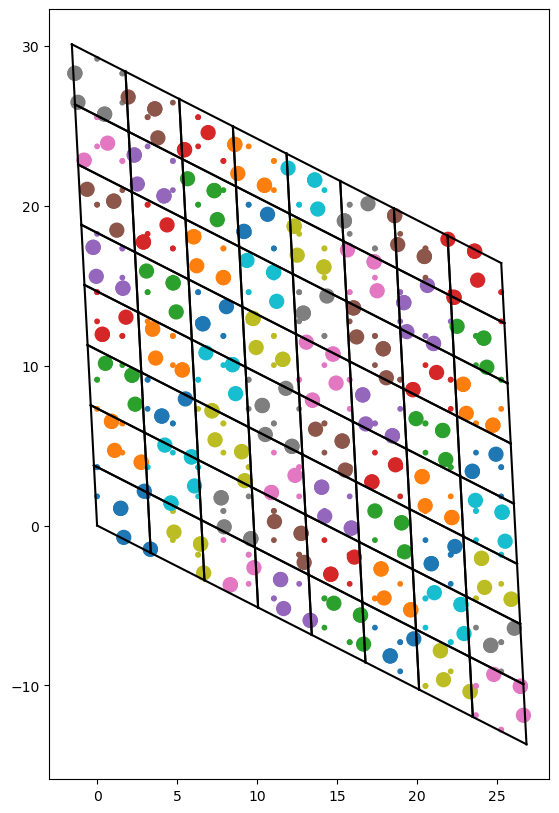

In [6]:
def create_grid(moire_atoms, n):
    """
    Subdivide the moiré cell into an n x n grid.
    
    Parameters:
    - cell_size: The size of the moiré cell.
    - n: The number of subdivisions along one axis.
    
    Returns:
    - A 2D array representing the grid points.
    """
    x = np.linspace(0, 1, n+1)
    y = np.linspace(0, 1, n+1)
    grid = np.meshgrid(x, y)

    n_unique_atom_types = len(np.unique(moire_atoms.arrays['atom_types']))
    print(n_unique_atom_types)
    moire_grid_atoms = []
    for i in range(n):
        grid_atoms_row = []
        for j in range(n):
            m1 = moire_atoms[np.logical_and(moire_atoms.get_scaled_positions()[:,0] < x[i+1], moire_atoms.get_scaled_positions()[:,0] > x[i] ) ]
            m1 = m1[np.logical_and(m1.get_scaled_positions()[:,1] < y[j+1], m1.get_scaled_positions()[:,1] > y[j] ) ]
            # m1.set_cell(moire_atoms.cell / np.array([n,n,1]))
            if len(np.unique(m1.arrays['atom_types'])) != n_unique_atom_types:
                print(f"WARNING: Grid cell ({i}, {j}) contains {len(np.unique(m1.arrays['atom_types']))} unique atom types")
                return None
            
            grid_atoms_row.append(m1)
        moire_grid_atoms.append(grid_atoms_row)


    return grid,moire_grid_atoms

def plot_moire_grid(moire, moire_grid, moire_grid_atoms):
    n_rows = len(moire_grid_atoms) + 1
    plt.figure(figsize=(10,10))
    # plt.scatter(moire.get_positions()[:,0],moire.get_positions()[:,1])
    for i in range(n):
        for j in range(n):
            plt.scatter(moire_grid_atoms[i][j].get_positions()[:,0],
                        moire_grid_atoms[i][j].get_positions()[:,1], 
                        s = np.where(moire_grid_atoms[i][j].positions[:,2] > moire_grid_atoms[i][j].positions[:,2].mean() , 100, 10))

    for i in range(n_rows-1):
        for j in range(n_rows-1):
            p1 = np.array([moire_grid[0][i, j], moire_grid[1][i, j]]) @ moire.cell[:2,:2]
            p2 = np.array([moire_grid[0][i+1, j], moire_grid[1][i+1, j] ]) @ moire.cell[:2,:2]
            p3 = np.array([moire_grid[0][i+1, j+1], moire_grid[1][i+1, j+1]]) @ moire.cell[:2,:2]
            p4 = np.array([moire_grid[0][i, j+1], moire_grid[1][i, j+1]]) @ moire.cell[:2,:2]
            # print(x0,y0)
            # Draw lines around each grid cell
            plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='black') # Bottom edge
            plt.plot([p2[0], p3[0]], [p2[1], p3[1]], color='black') # Right edge
            plt.plot([p3[0], p4[0]], [p3[1], p4[1]], color='black') # Top edge
            plt.plot([p4[0], p1[0]], [p4[1], p1[1]], color='black') # Left edge

    plt.axis('scaled')

n = 8
moire_grid,moire_grid_atoms = create_grid(moire,n)
plot_moire_grid(moire, moire_grid, moire_grid_atoms)

In [7]:
len(moire_grid_atoms)

8

In [11]:
def moire_grid_fingerprint(moire_grid_atoms):
    moire_grid_col_matrix = []
    for i in range(len(moire_grid_atoms)):
        moire_grid_col_matrix_row = []
        for j in range(len(moire_grid_atoms)):
            s = moire_grid_atoms[i][j].copy()
            
            s.cell = pristine_atoms.cell
            # test.positions,test.arrays['atom_types']
            idx_zero = np.argmin(np.linalg.norm(s.positions[s.arrays['atom_types'] == 0],axis = -1))
            pos_zero = s.positions[s.arrays['atom_types'] == 0][idx_zero]
            s.positions -= pos_zero
            unique_atom_types = np.unique(s.arrays['atom_types'])
            scaled_positions = s.get_scaled_positions()
            reduced_positions = np.zeros((len(unique_atom_types), 3))

            for u in unique_atom_types:
                scaled_positions_of_type = scaled_positions[s.arrays['atom_types'] == u]
                mean_scaled_positions = (((scaled_positions_of_type + 0.5) % 1) - 0.5).mean(axis=0)
                reduced_positions[u] = mean_scaled_positions 

            col_matrix = np.linalg.norm(reduced_positions[:,None] - reduced_positions[None,:],axis = -1)
            moire_grid_col_matrix_row.append({"reduced_positions":reduced_positions, 'col_matrix':col_matrix})
        moire_grid_col_matrix.append(moire_grid_col_matrix_row)
    return moire_grid_col_matrix

moire_grid_fingerprint = moire_grid_fingerprint(moire_grid_atoms)

def match_fingerprints(db_fingerprint, moire_grid_fingerprint, value = 'e_value'):
    moire_grid_value = []
    moire_grid_match_idx = []

    dp_fp_scaled_flat = np.array([f['fp_scaled'].flatten() for f in db_fingerprint])
    tree = cKDTree(dp_fp_scaled_flat)

    for i in range(len(moire_grid_fingerprint)):
        moire_grid_value_row = []
        moire_grid_match_idx_row = []
        for j in range(len(moire_grid_fingerprint)):
            grid_matrix = moire_grid_fingerprint[i][j]['col_matrix']
            distance, match_idx = tree.query(grid_matrix.flatten(), k = 1)

            match_value = db_fingerprint[match_idx][value]
            
            moire_grid_value_row.append(match_value)
            moire_grid_match_idx_row.append(match_idx)
        moire_grid_value.append(moire_grid_value_row)
        moire_grid_match_idx.append(moire_grid_match_idx_row)

    return moire_grid_match_idx, moire_grid_value

moire_grid_match_idx, moire_grid_value =  match_fingerprints(db_fingerprint, moire_grid_fingerprint)

In [9]:
moire_grid_value

[[-0.5149000000000001,
  -1.1689,
  -0.3122999999999998,
  -0.054200000000000026,
  -0.6430999999999998,
  -1.5196999999999998,
  -0.2622,
  -0.22489999999999988],
 [-1.5006999999999997,
  -0.2761,
  -0.5327000000000002,
  -0.5004000000000002,
  -0.27859999999999996,
  -0.3419000000000001,
  -1.5488,
  -0.5650999999999999],
 [-0.08640000000000003,
  -0.6476,
  -0.8199000000000001,
  -0.6476,
  -0.6256000000000002,
  -0.3282999999999998,
  -0.17779999999999996,
  -0.2941999999999998],
 [-0.15759999999999974,
  -0.1371,
  -0.14139999999999997,
  -0.15219999999999967,
  -0.5436999999999999,
  -1.6056,
  -1.6037000000000003,
  -0.0132000000000001],
 [-1.0578999999999998,
  -1.4474,
  -0.11129999999999995,
  -0.7853000000000001,
  -0.6588,
  -0.6477000000000002,
  -0.5567999999999997,
  -0.054200000000000026],
 [-0.20069999999999988,
  -0.28559999999999985,
  -0.3282999999999998,
  -0.8315999999999999,
  -1.0734999999999997,
  -0.8199000000000001,
  -0.2562000000000002,
  -0.853600000000000

In [245]:
n

8

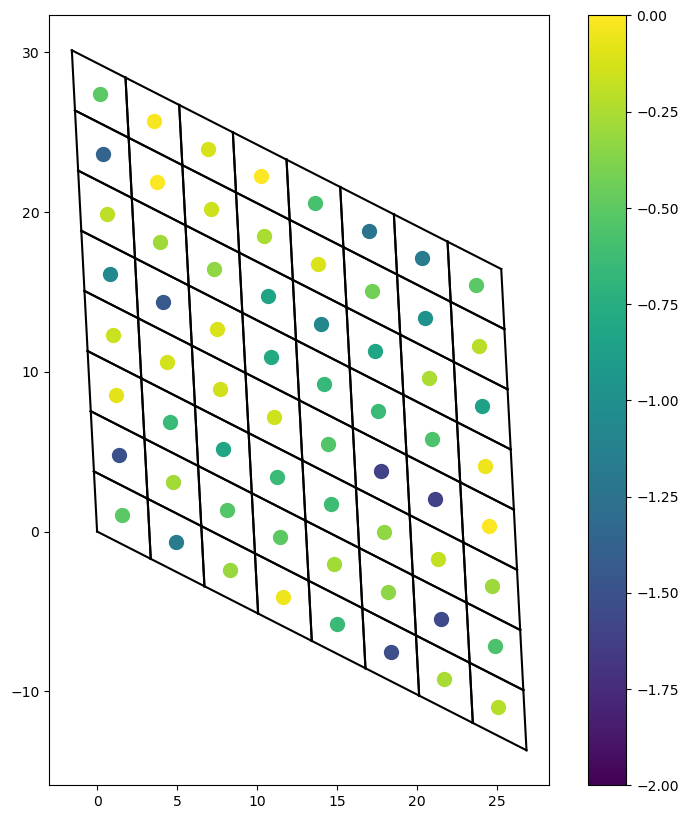

In [12]:
n_rows = len(moire_grid_atoms) + 1
plt.figure(figsize=(10,10))
# plt.scatter(moire.get_positions()[:,0],moire.get_positions()[:,1])
for i in range(n_rows - 1):
    for j in range(n_rows - 1):
        x0y0 = np.array([moire_grid[0][i][j] + 1/(2*n),
                         moire_grid[1][i][j] + 1/(2*n)])
        x0y0 = x0y0 @ moire.cell[:2,:2]
        
        plt.scatter(x0y0[0],
                    x0y0[1], 
                    c = moire_grid_value[i][j], s = 100, vmin = -2, vmax = 0, cmap = 'viridis')

for i in range(n_rows-1):
    for j in range(n_rows-1):
        p1 = np.array([moire_grid[0][i, j], moire_grid[1][i, j]]) @ moire.cell[:2,:2]
        p2 = np.array([moire_grid[0][i+1, j], moire_grid[1][i+1, j] ]) @ moire.cell[:2,:2]
        p3 = np.array([moire_grid[0][i+1, j+1], moire_grid[1][i+1, j+1]]) @ moire.cell[:2,:2]
        p4 = np.array([moire_grid[0][i, j+1], moire_grid[1][i, j+1]]) @ moire.cell[:2,:2]
        # print(x0,y0)
        # Draw lines around each grid cell
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='black',zorder = 0) # Bottom edge
        plt.plot([p2[0], p3[0]], [p2[1], p3[1]], color='black',zorder = 0) # Right edge
        plt.plot([p3[0], p4[0]], [p3[1], p4[1]], color='black',zorder = 0) # Top edge
        plt.plot([p4[0], p1[0]], [p4[1], p1[1]], color='black',zorder = 0) # Left edge

    plt.axis('scaled')
plt.colorbar()


In [14]:
t1 = moire_grid_fingerprint[0][0]['col_matrix']
t2 = db_fingerprint[0]['fp_scaled']

dp_fp_scaled_flat = np.array([f['fp_scaled'].flatten() for f in db_fingerprint])

tree = cKDTree(dp_fp_scaled_flat)
distance,index = tree.query(t1.flatten(), k = 1)
print(index)
dp_fp_scaled_flat[index].reshape(6,6)
db_test = np.around(db_fingerprint[index]['scaled_positions']@ pristine_atoms.cell,4)
moire_test = np.around(moire_grid_fingerprint[0][0]['reduced_positions']@ pristine_atoms.cell,4)

1649


In [15]:
clean_database[ii]

NameError: name 'ii' is not defined

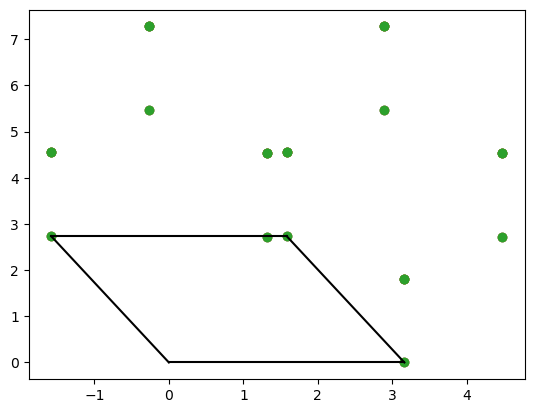

In [16]:
for i in [-1,0,1]:
    ii = index + 0
    plt.scatter(clean_database[ii].repeat((2,2,1)).positions[3:,0],clean_database[ii].repeat((2,2,1)).positions[3:,1], label = i)

p1 = np.array([0,0])
p2 = pristine_atoms.cell[0]
p3 = pristine_atoms.cell[0] + pristine_atoms.cell[1]
p4 = pristine_atoms.cell[1]
# print(x0,y0)
# Draw lines around each grid cell
plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='black') # Bottom edge
plt.plot([p2[0], p3[0]], [p2[1], p3[1]], color='black') # Right edge
plt.plot([p3[0], p4[0]], [p3[1], p4[1]], color='black') # Top edge
plt.plot([p4[0], p1[0]], [p4[1], p1[1]], color='black') # Left edge

(array([[ 0.    ,  0.    ,  0.    ],
        [ 1.5801, -0.9205,  1.5717],
        [ 1.5801, -0.9205, -1.5717],
        [-0.2693,  0.8958,  6.3434],
        [ 1.3108, -0.0247,  7.9152],
        [ 1.3108, -0.0247,  4.7717]]),
 array([[-0.    ,  0.    ,  0.    ],
        [ 1.5801, -0.9119,  1.5859],
        [ 1.5801, -0.9119, -1.5859],
        [-0.0608,  0.2456,  6.147 ],
        [ 1.6148, -0.6613,  7.7329],
        [ 1.6148, -0.6613,  4.5611]]))

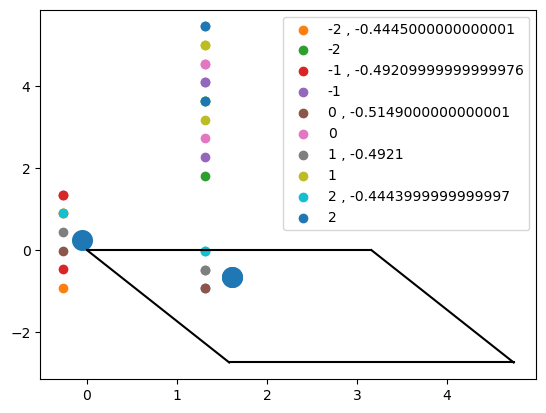

In [219]:
plt.scatter(moire_test[3:,0],moire_test[3:,1], s = 200)
for i in [-2,-1,0,1,2]:
    ii = index + i
    db_test = np.around(db_fingerprint[ii]['scaled_positions']@ pristine_atoms.cell,4)

    plt.scatter(db_test[3:,0],db_test[3:,1], label = f'{i} , {db_fingerprint[ii]["e_value"]}')
    plt.scatter(clean_database[ii].positions[3:,0],clean_database[ii].positions[3:,1], label = i)

p1 = np.array([0,0])
p2 = pristine_atoms.cell[0]
p3 = pristine_atoms.cell[0] - pristine_atoms.cell[1]
p4 = -pristine_atoms.cell[1]
# print(x0,y0)
# Draw lines around each grid cell
plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='black') # Bottom edge
plt.plot([p2[0], p3[0]], [p2[1], p3[1]], color='black') # Right edge
plt.plot([p3[0], p4[0]], [p3[1], p4[1]], color='black') # Top edge
plt.plot([p4[0], p1[0]], [p4[1], p1[1]], color='black') # Left edge

plt.legend()
db_test, moire_test

In [114]:
ss_scaled_positions = clean_database[0].get_scaled_positions()
ss_scaled_positions = (((ss_scaled_positions + 0.5) % 1) - 0.5)
ss_scaled_positions
np.linalg.norm(ss_scaled_positions[:,None] - ss_scaled_positions[None,:],axis = -1)

array([[0.        , 0.47897139, 0.47897139, 0.2621723 , 0.58254109,
        0.50689415],
       [0.47897139, 0.        , 0.1571723 , 0.50689415, 0.2621723 ,
        0.105     ],
       [0.47897139, 0.1571723 , 0.        , 0.58254109, 0.4193446 ,
        0.2621723 ],
       [0.2621723 , 0.50689415, 0.58254109, 0.        , 0.47897139,
        0.47897139],
       [0.58254109, 0.2621723 , 0.4193446 , 0.47897139, 0.        ,
        0.1571723 ],
       [0.50689415, 0.105     , 0.2621723 , 0.47897139, 0.1571723 ,
        0.        ]])

In [120]:
np.linalg.norm(db_fingerprint[0]['fp_scaled'] - col_matrix)/36

0.006919953795149488

In [74]:
import pymoire as pm

p = pm.materials.get_materials_db_path()
pristine_atoms = pm.read_monolayer(p/'MoS2.cif')
pristine_cell = pristine_atoms.cell
pristine_cell[2,2] = 20

def prepare_database(structures,pristine_cell):
    clean_database = []
    unique_atom_types = np.unique(structures[0].arrays['atom_types'])
    for ss in structures:
        s = ss.copy()
        s.positions -= s.positions[np.where(s.arrays['atom_types'] == 0)[0][0]]
        s.set_cell(pristine_cell)
        scaled_positions = s.get_scaled_positions()

        for u in unique_atom_types:
            scaled_positions_of_type = scaled_positions[s.arrays['atom_types'] == u]
            mean_scaled_positions = (((scaled_positions_of_type + 0.5) % 1) - 0.5).mean(axis=0)
            # print(u, mean_scaled_positions)

            scaled_positions[s.arrays['atom_types'] == u] = mean_scaled_positions 

        s.set_scaled_positions(scaled_positions)

        clean_atoms = Atoms()
        clean_atoms.set_cell(s.get_cell())
        clean_atoms.set_pbc(s.get_pbc())
        clean_atoms.info = s.info

        print(clean_atoms)
        for u in unique_atom_types:
           
            clean_atoms += s[s.arrays['atom_types'] == u][0]
            print(s[s.arrays['atom_types'] == u][0])
        clean_database.append(clean_atoms)

    return clean_database

clean_database = prepare_database(structures[:1],pristine_cell)

Atoms(symbols='', pbc=[True, True, False], cell=[[3.16021, 0.0, 0.0], [-1.5801049999999994, 2.7368221412936213, 0.0], [0.0, 0.0, 20.0]])
Atom('Mo', [-0.0035847950000003686, -0.006183935646810494, 0.0], index=0)
Atom('S', [1.5765202049999991, -0.9267032469404315, 1.5717229799999988], index=0)
Atom('S', [1.5765202049999991, -0.9267032469404315, -1.571722980000001], index=0)
Atom('Mo', [-0.0035847950000003686, -0.006183935646810494, 5.243445959999999], index=0)
Atom('S', [1.5765202049999991, -0.9267032469404315, 6.81516894], index=0)
Atom('S', [1.5765202049999991, -0.9267032469404315, 3.6717229800000006], index=0)


In [75]:
clean_database[0]

Atoms(symbols='MoS2MoS2', pbc=[True, True, False], cell=[[3.16021, 0.0, 0.0], [-1.5801049999999994, 2.7368221412936213, 0.0], [0.0, 0.0, 20.0]])

In [44]:
clean_database[1].get_scaled_positions() , clean_database[0].cell

(array([[ 0.99773588,  0.99774047,  0.        ],
        [ 0.32956286,  0.66139442,  0.07858615],
        [ 0.32956286,  0.66139442, -0.07858615],
        [ 0.99773588,  0.99774047,  0.        ],
        [ 0.32956286,  0.66139442,  0.07858615],
        [ 0.32956286,  0.66139442, -0.07858615],
        [ 0.0806925 ,  0.1636537 ,  0.2621723 ],
        [ 0.41251947,  0.82730765,  0.34075845],
        [ 0.41251947,  0.82730765,  0.18358615],
        [ 0.0806925 ,  0.1636537 ,  0.2621723 ],
        [ 0.41251947,  0.82730765,  0.34075845],
        [ 0.41251947,  0.82730765,  0.18358615],
        [ 0.99773588,  0.99774047,  0.        ],
        [ 0.32956286,  0.66139442,  0.07858615],
        [ 0.32956286,  0.66139442, -0.07858615],
        [ 0.0806925 ,  0.1636537 ,  0.2621723 ],
        [ 0.41251947,  0.82730765,  0.34075845],
        [ 0.41251947,  0.82730765,  0.18358615]]),
 Cell([[3.16021, 0.0, 0.0], [-1.5801049999999994, 2.7368221412936213, 0.0], [0.0, 0.0, 20.0]]))

In [63]:
# # [item for row in moire_grid_atoms for item in row]

# moire_grid_atoms[4][4].set_cell(pristine_cell)

# # moire_grid_atoms[0][0].cell

# structures_120 = structures.copy()
# for s in structures_120:
#     s.set_cell(pristine_cell)

structures[50].positions -= structures[50].positions[structures[50].arrays['atom_types']==0]
structures[50].cell = pristine_cell


In [64]:
write('moire_grid_atoms.xyz',[item for row in moire_grid_atoms for item in row], format="extxyz")
write('structures120.xyz',structures_120, format="extxyz")
write('test.cif',structures[50], format="cif")
write('test1.cif',structures_120[50], format="cif")

write('moire_grid_atoms_4_4.cif', moire_grid_atoms[4][4], format="cif")

/pscratch/sd/j/jdgeorga/ml_iaps/venv_ml_iaps/lib/python3.9/site-packages/ase/io/extxyz.py:1000: UserWarning: write_xyz() overwriting array "forces" present in atoms.arrays with stored results from calculator
  warnings.warn('write_xyz() overwriting array "{0}" present '


In [ ]:
def find_closest_match(grid_cell, database):
    """
    Find the closest matching atomic configuration in the database for the given grid cell.
    
    Parameters:
    - grid_cell: The atomic positions in the current grid cell.
    - database: A data structure holding atomic configurations and their energy values.
    
    Returns:
    - The energy value of the closest matching configuration.
    """
    # Logic to compare `grid_cell` with entries in `database` and find the closest match
    # This is highly dependent on the structure of your database and the data format
    closest_match_energy = ...  # Placeholder for actual logic
    return closest_match_energy

In [ ]:
def assign_energy_values(grid, database):
    """
    Assign energy values to each grid cell based on the closest match in the database.
    
    Parameters:
    - grid: The 2D array of grid points.
    - database: The database of atomic configurations and energy values.
    
    Returns:
    - A 2D array of energy values for each grid cell.
    """
    energy_grid = np.zeros_like(grid[0])  # Assuming grid[0] and grid[1] have the same shape
    for i in range(grid[0].shape[0]):
        for j in range(grid[0].shape[1]):
            grid_cell = ...  # Extract atomic positions for the grid cell at (i, j)
            energy_grid[i, j] = find_closest_match(grid_cell, database)
    return energy_grid

In [ ]:
from numpy.fft import fft2

def apply_fourier_transform(energy_grid):
    """
    Apply a Fourier transform to the grid of energy values.
    
    Parameters:
    - energy_grid: A 2D array of energy values for each grid cell.
    
    Returns:
    - The Fourier transform of the energy grid.
    """
    fourier_transform = fft2(energy_grid)
    return fourier_transform